In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read parquet file into a DataFrame
data = pd.read_parquet(r"/content/data_truebeacon.parquet")

# Display the DataFrame
data

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [3]:
# Checking null values in the DataFrame
data.isnull().sum()

banknifty    1500
nifty        2000
tte             0
dtype: int64

There are few missing values in the given data set, we can fill those using internpolation.

In [4]:
# Interpolate missing values using linear interpolation method
data = data.interpolate(method='linear')

# Checking null values in the DataFrame
data.isnull().sum()

banknifty    0
nifty        0
tte          0
dtype: int64

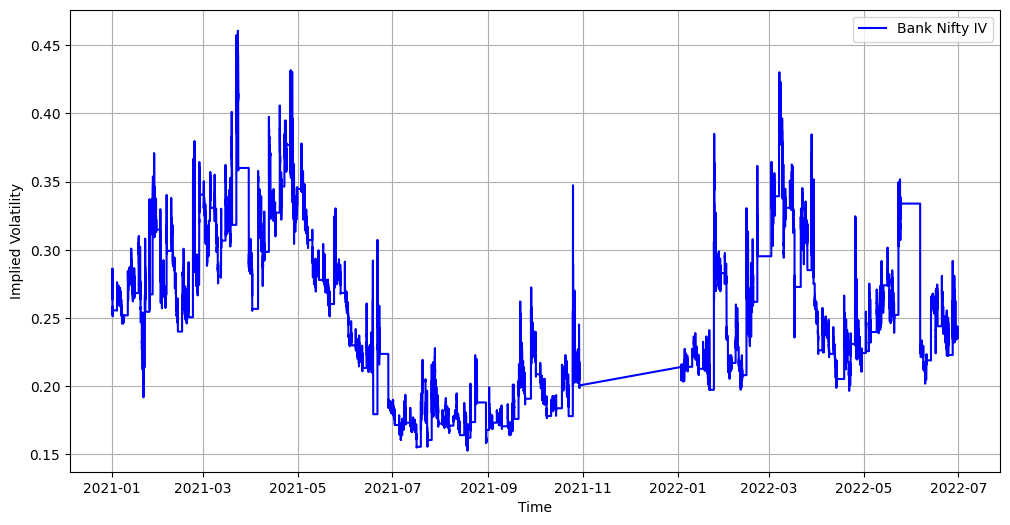

In [15]:
# Plotting minute-level implied volatility for Bank Nifty
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['banknifty'], label='Bank Nifty IV', color='blue', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Minute-Level Implied Volatilities')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.show()

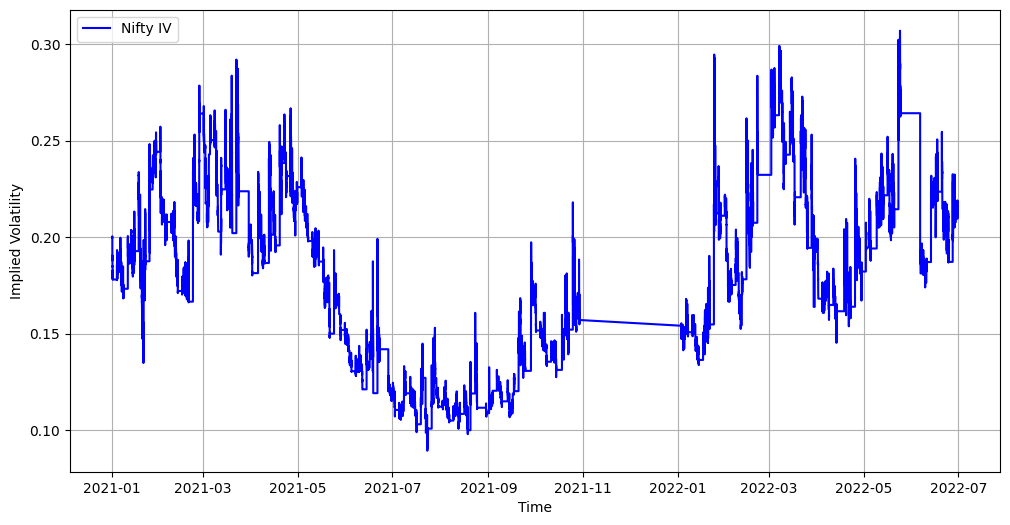

In [16]:
# Plotting minute-level implied volatility for Nifty
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['nifty'], label='Nifty IV', color='blue', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Minute-Level Implied Volatilities')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.show()

The similarity in implied volatilities plots of Nifty and Bank Nifty arises from their close correlation, shared market conditions, and common drivers such as economic indicators and investor sentiment. Interdependence between sectors, consistent trading strategies, and uniform data sources further contribute to the parallel movements observed in their volatility trends.

In [8]:
# Calculate the spread between Bank Nifty and Nifty implied volatilities
data['spread'] = data['banknifty'] - data['nifty']

# Calculate profit/loss based on the spread and time to expiry
data['P/L'] = data['spread'] * (data['tte'] ** 0.7)

data

,banknifty,nifty,tte,spread,P/L
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.267320
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.250560
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.260910


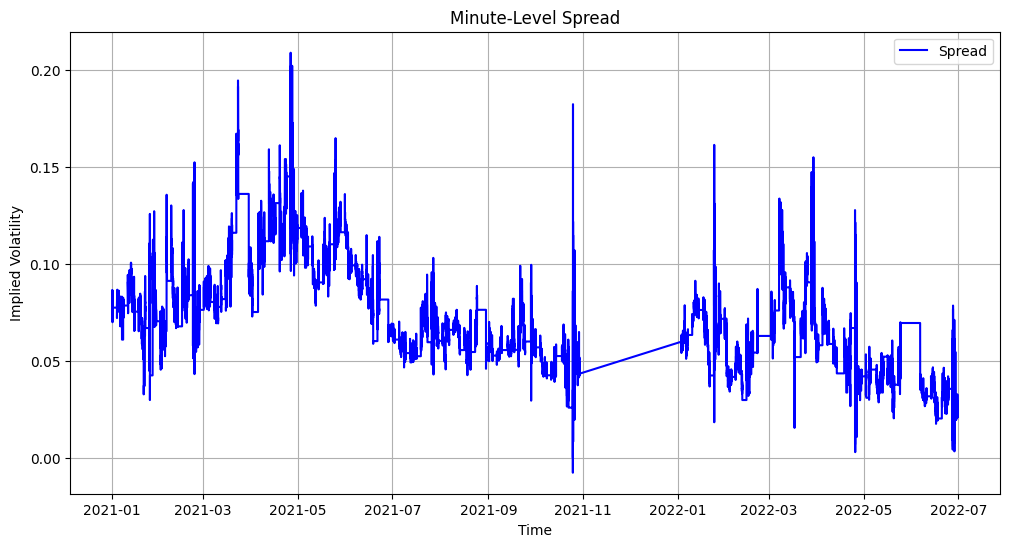

In [19]:
# Plotting minute-level Spread
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['spread'], label='Spread', color='blue', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Minute-Level Spread')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.show()

In [25]:
import pandas as pd
import numpy as np

# Define a range of thresholds for grid search
th_range = np.arange(0, 2.0, 0.05)

# Initialize variables to store optimum threshold and total profit
opt_th = None  # Store the threshold value that maximizes profit
opt_win = None  # Store the window size that maximizes profit
max_tot_prof = float('-inf')  # Store the maximum total profit obtained

# Perform grid search for optimum threshold
for th in th_range:
    for win_size in range(30, 375, 15):
        # Make a copy of the original DataFrame for each iteration
        data_copy = data.copy()

        # Calculate spread between BankNifty IV and Nifty IV
        data_copy['spread'] = data_copy['banknifty'] - data_copy['nifty']

        # Calculate Z-score for the spread
        data_copy['Z_Score'] = (data_copy['spread'] - data_copy['spread'].rolling(window=win_size).mean()) / data_copy['spread'].rolling(window=win_size).std()
        data_copy.dropna(subset=['Z_Score'], inplace=True)

        # Define entry and exit signals based on the threshold
        data_copy['Signal'] = 0
        data_copy.loc[data_copy['Z_Score'] > th, 'Signal'] = -1  # Short BankNifty IV, Long Nifty IV
        data_copy.loc[data_copy['Z_Score'] < -th, 'Signal'] = 1  # Long BankNifty IV, Short Nifty IV

        # Calculate profit/loss based on the trading signals and time to expiry
        data_copy['Position'] = data_copy['Signal'].shift(1)  # Shift signal by one day to avoid look-ahead bias
        data_copy['P/L'] = data_copy['spread'] * data_copy['Position'] * (data_copy['tte'] ** 0.7)

        # Calculate total profit
        tot_prof = data_copy['P/L'].sum()

        # Update optimal threshold, window size, and total profit if the current profit is higher
        if tot_prof > max_tot_prof:
            opt_th = th
            opt_win = win_size
            max_tot_prof = tot_prof

# Print optimal threshold, window size, and total profit
print("Optimal Window Size:", opt_win)
print("Optimal Threshold:", opt_th)
print("Total Profit:", max_tot_prof)


Optimal Window Size: 360
Optimal Threshold: 0.1
Total Profit: 3619.1699480548627


In [34]:
th = 0.1
win_size = 360

# Make a copy of the original DataFrame for each iteration
data_copy = data.copy()

data_copy['Z_Score'] = (data_copy['spread'] - data_copy['spread'].rolling(window=win_size).mean()) / data_copy['spread'].rolling(window=win_size).std()
data_copy.dropna(subset=['Z_Score'], inplace=True)

# Define entry and exit signals based on the threshold
data_copy['Signal'] = 0
data_copy.loc[data_copy['Z_Score'] > th, 'Signal'] = -1  # Short BankNifty IV, Long Nifty IV
data_copy.loc[data_copy['Z_Score'] < -th, 'Signal'] = 1  # Long BankNifty IV, Short Nifty IV

# Calculate profit/loss based on the trading signals and time to expiry
data_copy['Position'] = data_copy['Signal'].shift(1)  # Shift signal by one day to avoid look-ahead bias
data_copy['P/L'] = data_copy['spread'] * data_copy['Position'] * (data_copy['tte'] ** 0.7)

# Calculate total profit
tot_prof = data_copy['P/L'].sum()

print(tot_prof)


3619.1699480548627
